In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
import re
import requests
import time
from datetime import datetime
from datetime import timezone
import csv
import mwparserfromhell
import sys
import tqdm

In [2]:
df = pd.read_csv('../../datas/final/large_db_preprocess.csv')
articles = sorted(df['article'].unique().tolist())

## CT Articles

In [13]:
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

# same idea as the protection status

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer",
        "rvslots": "main",
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }

# as explained, we are collection every article Talk Page revisions.
def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

def extract_metadata(wikitext):
    """
    Detect whether the talk page contains a Contentious Topics (CT) talk notice.

    Catches:
      - {{Contentious topics/talk notice|...}}
      - {{Contentious topics/<topic> talk notice|...}}  (topic-specific wrappers)
      - {{Ct/tn|...}} (shortcut/redirect)

    Returns:
        {"contentious": True/False}
    """

    def _extract_templates_balanced(text):
        templates = []
        n = len(text)
        i = 0

        while i < n - 1:
            if text[i:i+2] != "{{":
                i += 1
                continue

            depth = 0
            j = i
            while j < n - 1:
                two = text[j:j+2]
                if two == "{{":
                    depth += 1
                    j += 2
                    continue
                if two == "}}":
                    depth -= 1
                    j += 2
                    if depth == 0:
                        templates.append(text[i:j])
                        break
                    continue
                j += 1

            i += 2

        return templates

    def _template_name(template_wikitext):
        inner = template_wikitext.strip()
        if inner.startswith("{{"):
            inner = inner[2:]
        if inner.endswith("}}"):
            inner = inner[:-2]

        name = inner.split("|", 1)[0].strip().lower()
        name = name.replace("_", " ")
        name = re.sub(r"\s+", " ", name)
        return name

    # Exact names we want to catch (including shortcut)
    EXACT_TARGETS = {
        "contentious topics/talk notice",
        "ct/tn",  # shortcut / redirect listed in the template docs
    }

    # Pattern for topic-specific wrapper names, e.g.
    # "contentious topics/gmo talk notice", "contentious topics/the troubles talk notice", etc.
    TOPIC_WRAPPER_RE = re.compile(r"^contentious topics/.+ talk notice$")

    contentious_bool = False

    for tpl in _extract_templates_balanced(wikitext):
        name = _template_name(tpl)

        if name in EXACT_TARGETS:
            contentious_bool = True
            break

        if TOPIC_WRAPPER_RE.match(name):
            contentious_bool = True
            break

    return {"contentious": contentious_bool}

# Same idea as for the protection status
def build_metadata_timeline(talk_revisions):
    """
    Build a compact change timeline.
    Only records entries when the contentious flag changes.

    Output:
    [
        {"timestamp": "...", "rev_id": ..., "contentious": True/False},
        ...
    ]
    """
    timeline = []
    last_state = {"contentious": None}

    for rev in talk_revisions:
        meta = extract_metadata(rev["content"])

        if meta != last_state:
            timeline.append(
                {
                    "timestamp": rev["timestamp"],
                    "rev_id": rev["rev_id"],
                    **meta,
                }
            )
            last_state = meta.copy()

    return timeline


def extract_article_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing contentious-topic metadata changes ===")
    timeline = build_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline


def contentious_timelines_to_dataframe(timelines):
    """
    Convert {article: [change_points...]} into a DataFrame of *intervals*:

        article | start | end | contentious | diff_days

    Notes:
    - all datetimes are UTC-aware
    - if no change points exist, we output a single "Unspecified" interval
      from creation date (if available) to now.
    """
    rows = []
    now_utc = pd.Timestamp.now(tz=timezone.utc)

    for article, changes in timelines.items():
        if not changes:
            creation_info = get_article_creation_date(article)
            start = (
                pd.to_datetime(creation_info["timestamp"], utc=True)
                if creation_info and "timestamp" in creation_info
                else pd.NaT
            )

            rows.append(
                {
                    "article": article,
                    "start": start,
                    "end": now_utc,
                    "contentious": "Unspecified",
                    "diff_days": (now_utc - start).days if pd.notna(start) else None,
                }
            )
            continue

        df = pd.DataFrame(changes)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df.sort_values("timestamp")

        df["end"] = df["timestamp"].shift(-1).fillna(now_utc)

        for _, r in df.iterrows():
            start = r["timestamp"]
            end = r["end"]
            val = r["contentious"]

            rows.append(
                {
                    "article": article,
                    "start": start,
                    "end": end,
                    "contentious": val if val is not None else "Unspecified",
                    "diff_days": (end - start).days if pd.notna(start) and pd.notna(end) else None,
                }
            )

    return pd.DataFrame(rows)


def plot_contentious_timeline(contentious_df: pd.DataFrame, wanna_save_fig: bool = False, save_path: str = None):
    """
    Gantt-style timeline representing contentious-tag evolution.

    Input columns:
        - article
        - start
        - end
        - contentious  (True/False/"Unspecified")
    """
    CONTENTIOUS_COLORS = {
        True: "blue",
        False: "orange",
        "Unspecified": "lightgray",
    }

    if contentious_df is None or contentious_df.empty:
        raise ValueError("contentious_df is empty. Nothing to plot.")

    df = contentious_df.copy()

    required = {"article", "start", "end", "contentious"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"contentious_df is missing required columns: {sorted(missing)}")

    df["start"] = pd.to_datetime(df["start"], utc=True, errors="coerce")
    df["end"] = pd.to_datetime(df["end"], utc=True, errors="coerce")

    df = df.dropna(subset=["article", "start", "end"])
    df = df[df["end"] > df["start"]]

    if df.empty:
        raise ValueError("After cleaning invalid intervals, nothing remains to plot.")

    articles = sorted(df["article"].unique())
    fig, ax = plt.subplots(figsize=(14, max(2, len(articles) * 0.4)))
    height = 0.8

    for y_pos, article in enumerate(articles):
        subset = df[df["article"] == article].sort_values("start")

        for _, row in subset.iterrows():
            start = row["start"].to_pydatetime()
            end = row["end"].to_pydatetime()
            val = row["contentious"]

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=CONTENTIOUS_COLORS.get(val, "black"),
                edgecolor="none",
            )

        first_start = subset["start"].iloc[0].to_pydatetime()
        ax.text(
            mdates.date2num(first_start) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right",
        )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend_handles = [Patch(facecolor=c, label=str(lbl)) for lbl, c in CONTENTIOUS_COLORS.items()]
    ax.legend(
        handles=legend_handles,
        title="Contentious tag",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
    )

    plt.title("Wikipedia Contentious Topics Tag Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        if save_path is None:
            save_path = "../../plots/Policy Analysis/contentious_timeline.png"
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [27]:
contentious_timelines = {} # needed to build the timelines and build the plot 
contentious_timelines_full = {}

for title in cleaned_titles:
    #contentious_timelines[title] = extract_article_metadata_timeline(title)
    contentious_timelines_full[title] = extract_article_metadata_timeline(title)

#contentious_df = contentious_timelines_to_dataframe(contentious_timelines)
contentious_df_full = contentious_timelines_to_dataframe(contentious_timelines_full)


=== Fetching Talk Page revisions for: COVID-19 pandemic in Ukraine ===


KeyboardInterrupt: 

In [10]:
contentious_df.to_csv('../../datas/interim/Policy Analysis/ct_article_timline.csv')

In [ ]:
def clean_contentious_df(dataframe):
    df = dataframe.copy()
    df['importance'] = (
    df['importance']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

contentious_df_clean = clean_contentious_df(contentious_df)

In [ ]:
plot_contentious_timeline(contentious_df_clean, False)

In [15]:
contentious_df = contentious_timelines_to_dataframe(contentious_timelines)
contentious_df

,article,start,end,contentious,diff_days
0,2004 Ukrainian presidential election,2004-11-10 06:38:50+00:00,2026-02-03 21:42:43.931701+00:00,False,7755
1,2014 Russian annexation of Crimea,2014-03-18 02:27:41+00:00,2024-03-08 19:25:32+00:00,False,3643
2,2014 Russian annexation of Crimea,2024-03-08 19:25:32+00:00,2026-02-03 21:42:43.931701+00:00,True,697
3,2014 pro-Russian unrest in Ukraine,2014-03-06 07:37:55+00:00,2024-03-08 19:30:42+00:00,False,3655
4,2014 pro-Russian unrest in Ukraine,2024-03-08 19:30:42+00:00,2026-02-03 21:42:43.931701+00:00,True,697
5,2022 Russian invasion of Ukraine,2025-09-24 13:01:19+00:00,2026-02-03 21:42:43.931701+00:00,False,132
6,Abortion in Ukraine,2014-03-27 00:09:30+00:00,2026-02-03 21:42:43.931701+00:00,False,4331
7,Administrative divisions of Ukraine,2004-09-04 20:57:49+00:00,2026-02-03 21:42:43.931701+00:00,False,7822
8,Alexander II of Russia,2003-05-02 17:26:26+00:00,2026-02-03 21:42:43.931701+00:00,False,8313
9,Armed Forces of Ukraine,2004-09-28 16:31:38+00:00,2026-02-03 21:42:43.931701+00:00,False,7798


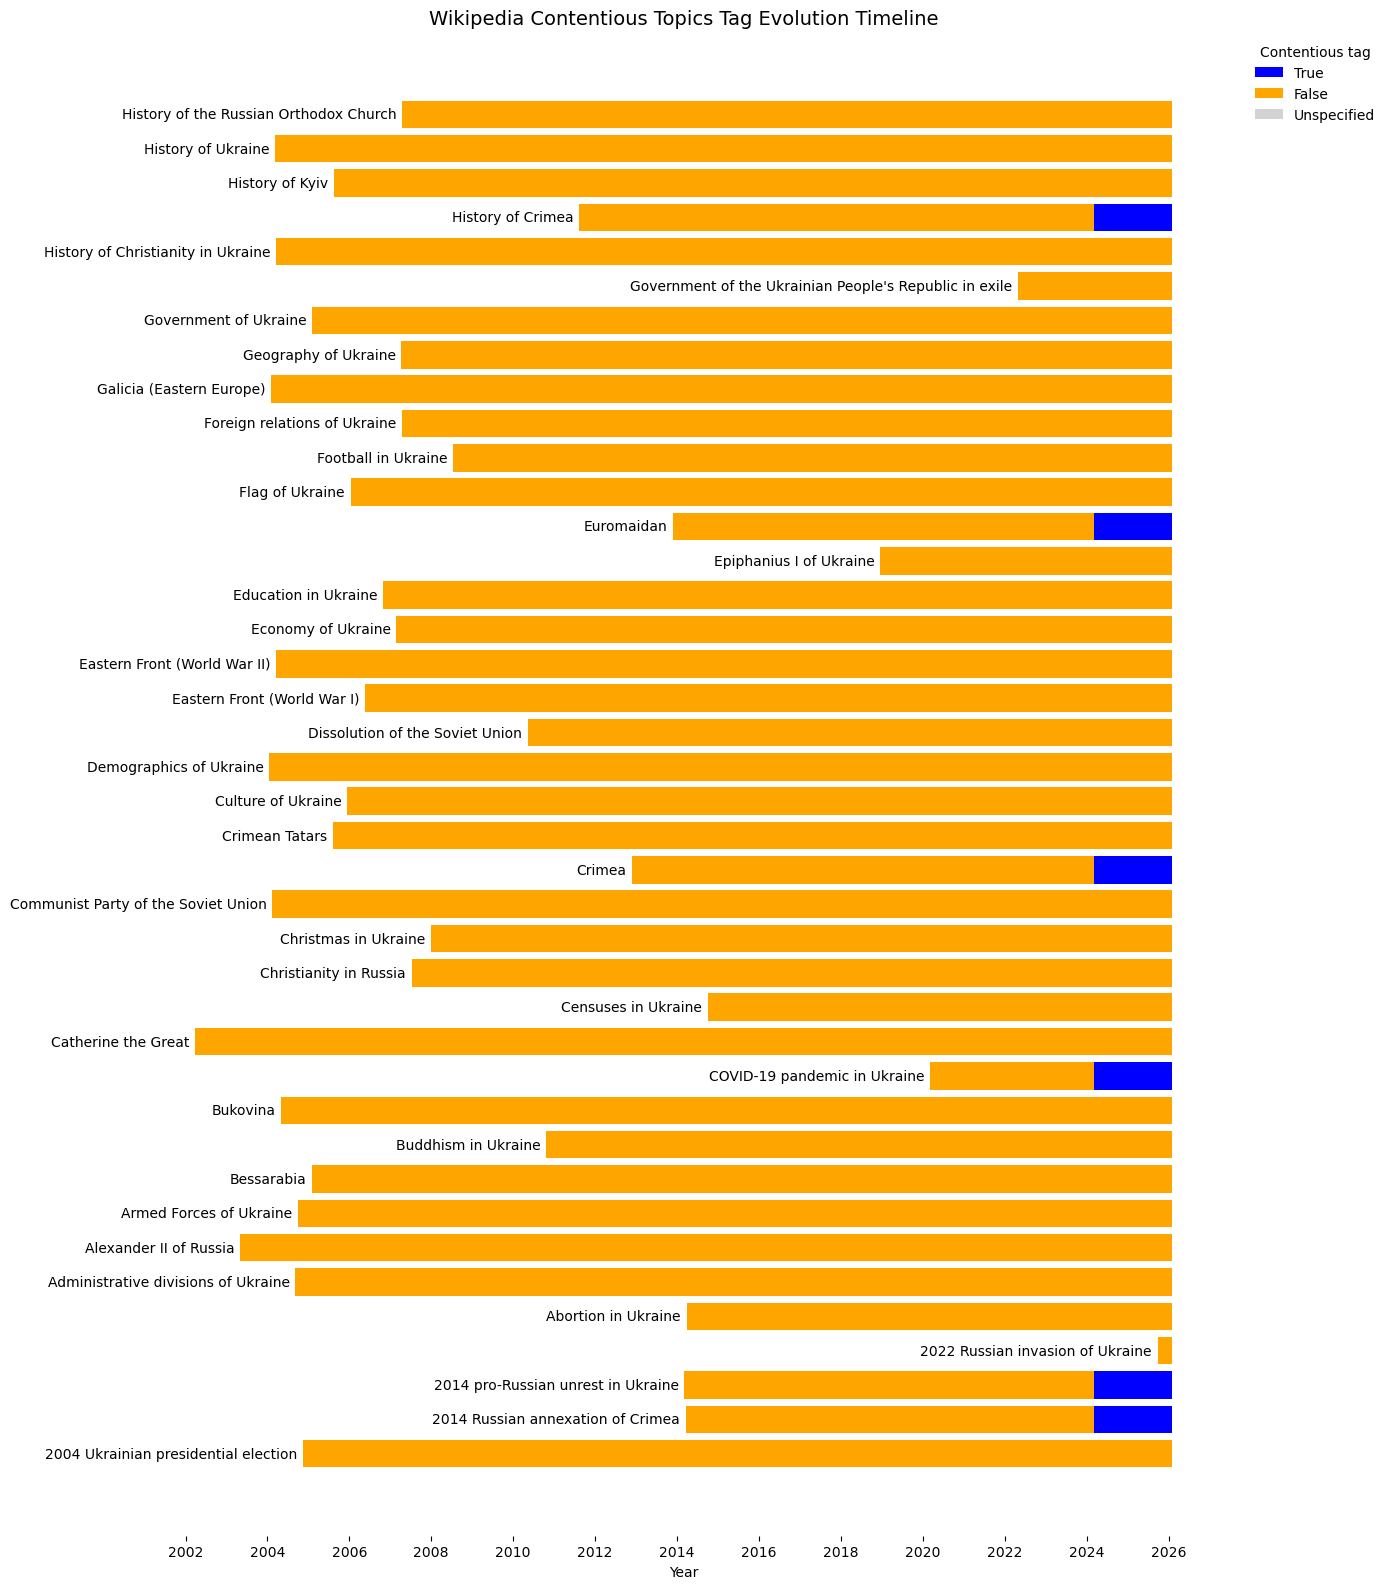

In [14]:
plot_contentious_timeline(contentious_df)

In [20]:
def match_features_with_df(contentious_dataframe, dataframe):

    df = dataframe.copy()
    
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df = df.sort_values('date', ascending=False)
    
    for idx, row in df.iterrows():
        article = row["article"]
        date_df = row["date"]
    
        # find the timeline rows for this article
        contentious_subset = contentious_dataframe[contentious_dataframe["article"] == article]
    
        # loop over intervals for this article for grade_dataframe
        for _, tc in contentious_subset.iterrows():
            contentious_start = tc["start"]
            contentious_end   = tc["end"]
    
            # check if the date is within that interval
            if contentious_start <= date_df < contentious_end:
                df.loc[idx, "contentious"] = tc["contentious"]
                break    

    return df

def plot_weap_vs_contentious(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'contentious']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", False, True]

    df_plot["contentious"] = pd.Categorical(df_plot["contentious"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="contentious", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Distribution of Weaponised vs Not Weaponised Edits by Contentious Tag"
    else:
        y_label = "Count"
        title = "Edit Count by Contentious Tag and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Contentious Tag")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

In [21]:
df_final = match_features_with_df(contentious_df, df)

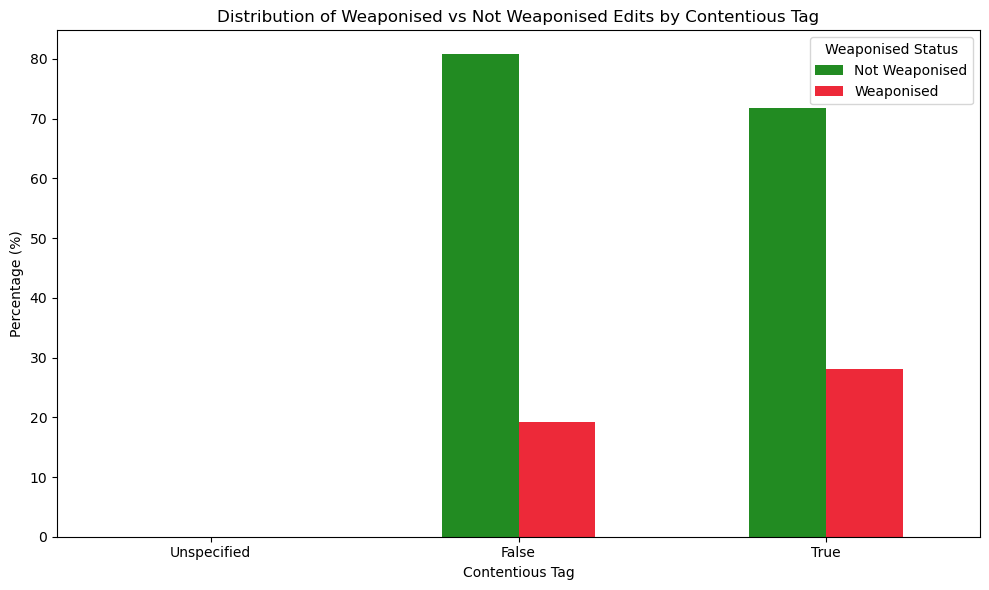

In [23]:
plot_weap_vs_contentious(df_final, False, 'percentage')